# **Задача прогнозирования температуры**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def mk_dir(name):
    if(os.path.isdir(name)==False):
        os.mkdir(name)

In [ ]:
import zipfile
import os
import requests

In [ ]:
import os
import requests
mk_dir('/content/drive/MyDrive/Datasets/jena_climate')
url = 'https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip'
q = requests.get(url)
result = q.content
#result = q.content


In [ ]:
with open('jena_climate_2009_2016.csv.zip', 'wb') as f:
    f.write(result)

In [ ]:
with zipfile.ZipFile('jena_climate_2009_2016.csv.zip', 'r') as z:
    z.extractall(os.path.join('/content/drive/MyDrive/Datasets/jena_climate'))

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Datasets/jena_climate/jena_climate_2009_2016.csv')

In [ ]:
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420446,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420447,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420448,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420449,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [ ]:
# Обзор набора метеорологических данных Jena

data_dir = '/content/drive/MyDrive/Datasets/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

with open(fname) as f:
  data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [ ]:
# Преобразование данных
# Столбец с датой и временем исключен

import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

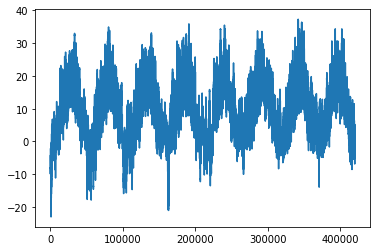

In [ ]:
# Создание графика изменения температуры

from matplotlib import pyplot as plt

temp = float_data[:, 1] # температура (в градусах Цельсия)
plt.plot(range(len(temp)), temp)

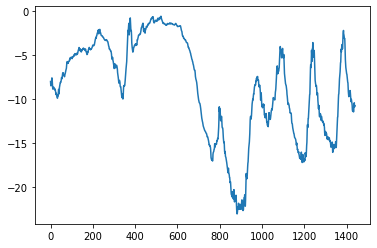

In [ ]:
# Создание графика изменения температуры по данным за первые 10 дней

plt.plot(range(1440), temp[:1440])

# **Подготовка данных**

In [ ]:
lookback = 720 # количество наблюдений за предыдущие 5 дней
step = 6       # шаг отбора образцов из наблюдений, то есть один образец за каждый час
delay = 144    # целью являются следующие 24 часа в будущем

In [ ]:
# Нормализация данных
# Стандартизируем только первые 200000 замеров для обучающей выборки

mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [ ]:
# Функция-генератор, возвращающая временные последовательности образцов и их целей

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                    min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                        lookback // step,
                        data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


In [ ]:
lookback = 720 
step = 6       
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

#Сколько раз нужно обратиться к val_gen, чтобы получить проверочный набор данных целиком
val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

# **Базовое решение без привлечения машинного обучения**

In [ ]:
np.mean(np.abs(preds - targets))

NameError: ignored

In [ ]:
# Оценка базового решения MAE

def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
evaluate_naive_method()

0.2905218778760465


In [ ]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

# **Базовое решение c привлечением машинного обучения**

In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.
shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 12s 19ms/step - loss: 0.4328 - val_loss: 0.3490
Epoch 2/20
500/500 [==============================] - 9s 19ms/step - loss: 0.3021 - val_loss: 0.3141
Epoch 3/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2583 - val_loss: 0.3088
Epoch 4/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2466 - val_loss: 0.2975
Epoch 5/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2313 - val_loss: 0.3068
Epoch 6/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2253 - val_loss: 0.3024
Epoch 7/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2223 - val_loss: 0.3087
Epoch 8/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2171 - val_loss: 0.3028
Epoch 9/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2127 - val_loss: 0.3061
Epoch 10/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2093 - v

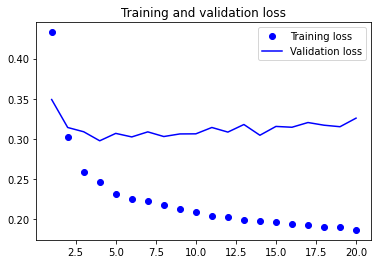

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# **Первое базовое рекуррентное решение**

In [ ]:
# Обучение и оценка модели на основе GRU (Проще, чем LSTM и быстрее)

from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 23s 37ms/step - loss: 0.3127 - val_loss: 0.2722
Epoch 2/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2844 - val_loss: 0.2675
Epoch 3/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2778 - val_loss: 0.2641
Epoch 4/20
500/500 [==============================] - 18s 37ms/step - loss: 0.2716 - val_loss: 0.2639
Epoch 5/20
500/500 [==============================] - 18s 37ms/step - loss: 0.2614 - val_loss: 0.2630
Epoch 6/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2562 - val_loss: 0.2631
Epoch 7/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2523 - val_loss: 0.2709
Epoch 8/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2460 - val_loss: 0.2686
Epoch 9/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2405 - val_loss: 0.2737
Epoch 10/20
500/500 [==============================] - 18s 36ms/step - loss: 0.234

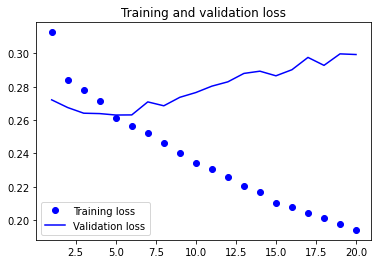

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# **Использование рекуррентного прореживания для борьбы с переобучением**

In [ ]:
# Обучение и оценка модели на основе GRU с регуляризацией прореживанием

from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(layers.GRU(32,
          dropout=0.2,
          recurrent_dropout=0.2,
          input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
500/500 [==============================] - 345s 686ms/step - loss: 0.3284 - val_loss: 0.2890
Epoch 2/40
500/500 [==============================] - 340s 681ms/step - loss: 0.3052 - val_loss: 0.2717
Epoch 3/40
500/500 [==============================] - 340s 680ms/step - loss: 0.2985 - val_loss: 0.2710
Epoch 4/40
500/500 [==============================] - 340s 680ms/step - loss: 0.2925 - val_loss: 0.2717
Epoch 5/40
500/500 [==============================] - 338s 676ms/step - loss: 0.2869 - val_loss: 0.2789
Epoch 6/40
500/500 [==============================] - 333s 665ms/step - loss: 0.2813 - val_loss: 0.2742
Epoch 7/40
500/500 [==============================] - 337s 673ms/step - loss: 0.2769 - val_loss: 0.2801
Epoch 8/40
500/500 [==============================] - 339s 679ms/step - loss: 0.2724 - val_loss: 0.2753
Epoch 9/40
500/500 [==============================] - 340s 680ms/step - loss: 0.2716 - val_loss: 0.2732
Epoch 10/40
442/500 [=========================>....] - ETA: 36s 

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# **Наложение нескольких рекуррентных слоев друг на друга**

Избавившись от эффекта переобучения, мы столкнулись с проблемой низкого
качества, поэтому теперь нужно подумать об увеличении емкости сети. Вспомните
описание обобщенного процесса машинного обучения: рекомендуется всегда стараться увеличивать емкость сети, пока на первое место не выйдет проблема переобучения (при условии, что предприняты все основные меры против нее, такие как
прореживание). Пока проблема переобучения не стоит остро, вероятно, сеть имеет
недостаточную емкость.

Увеличение емкости сети обычно осуществляется за счет увеличения числа параметров слоя или добавления дополнительных слоев. Наложение рекуррентных слоев
друг на друга — классический способ конструирования более мощных рекуррентных сетей: например, в настоящее время алгоритм Google Translate представляет
собой стек из семи больших слоев LSTM — это огромная сеть.

При наложении друг на друга рекуррентных слоев в Keras все промежуточные
слои должны возвращать полные выходные последовательности (трехмерный
тензор), а не только последний интервал. Это достигается установкой параметра
return_sequences=True.

In [ ]:
# Обучение и оценка модели с несколькими слоями GRU и с регуляризацией прореживанием

model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.1,
                    recurrent_dropout=0.5,
                    return_sequences=True,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(32, activation='relu',
                    dropout=0.1,
                    recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)


In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# **Использование двунаправленных рекуррентных нейронных сетей**

In [1]:
# Обучение и оценка LSTM на обращенных последовательностях

from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(
            num_words=max_features) 

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]                          # Обращение последовательностей
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

17473536/17464789 [==============================] - 0s 0us/step


In [2]:
model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 18s 71ms/step - loss: 0.5374 - acc: 0.7302 - val_loss: 0.4443 - val_acc: 0.8206
Epoch 2/10
157/157 [==============================] - 10s 65ms/step - loss: 0.3469 - acc: 0.8601 - val_loss: 0.3767 - val_acc: 0.8388
Epoch 3/10
157/157 [==============================] - 10s 66ms/step - loss: 0.2539 - acc: 0.9071 - val_loss: 0.3499 - val_acc: 0.8650
Epoch 4/10
157/157 [==============================] - 10s 67ms/step - loss: 0.1906 - acc: 0.9342 - val_loss: 0.3719 - val_acc: 0.8606
Epoch 5/10
157/157 [==============================] - 10s 66ms/step - loss: 0.1436 - acc: 0.9524 - val_loss: 0.3955 - val_acc: 0.8594
Epoch 6/10
157/157 [==============================] - 10s 66ms/step - loss: 0.1240 - acc: 0.9604 - val_loss: 0.4320 - val_acc: 0.8620
Epoch 7/10
157/157 [==============================] - 10s 66ms/step - loss: 0.0930 - acc: 0.9699 - val_loss: 0.5169 - val_acc: 0.8528
Epoch 8/10
157/157 [==============================] - 10s 66ms

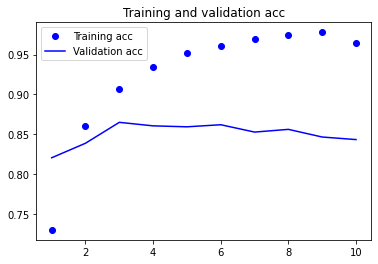

In [4]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.show()

In [5]:
# Обучение и оценка двунаправленной модели LSTM

model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)


Epoch 1/10
157/157 [==============================] - 33s 189ms/step - loss: 0.6188 - acc: 0.6592 - val_loss: 0.4626 - val_acc: 0.7978
Epoch 2/10
157/157 [==============================] - 29s 183ms/step - loss: 0.3539 - acc: 0.8579 - val_loss: 0.3188 - val_acc: 0.8772
Epoch 3/10
157/157 [==============================] - 29s 184ms/step - loss: 0.2341 - acc: 0.9133 - val_loss: 0.3175 - val_acc: 0.8810
Epoch 4/10
157/157 [==============================] - 29s 184ms/step - loss: 0.1751 - acc: 0.9407 - val_loss: 0.3361 - val_acc: 0.8688
Epoch 5/10
157/157 [==============================] - 29s 183ms/step - loss: 0.1316 - acc: 0.9574 - val_loss: 0.3760 - val_acc: 0.8752
Epoch 6/10
157/157 [==============================] - 29s 184ms/step - loss: 0.1091 - acc: 0.9669 - val_loss: 0.4377 - val_acc: 0.8702
Epoch 7/10
157/157 [==============================] - 29s 184ms/step - loss: 0.1028 - acc: 0.9673 - val_loss: 0.4062 - val_acc: 0.8584
Epoch 8/10
157/157 [==============================] - 2

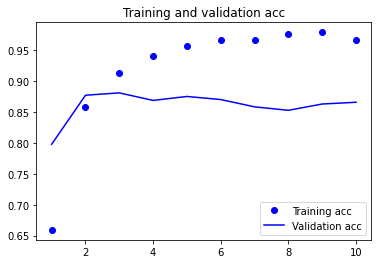

In [7]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.show()

In [ ]:
# Обучение двунаправленной модели GRU (погода)

from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

model = Sequential()
model.add(layers.Bidirectional(
            layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()